In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.9 MB/s 


# Importation des librairies et de la base de données

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as sts
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#Models librairies
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
#Metrics Librairies
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#Normalize values
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/energy_batiment.csv')
df=df.iloc[:, 1:]
df.head()

,BuildingType,PrimaryPropertyType,Address,ZipCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions
0,NonResidential,Hotel,405 Olive way,98101.0,DOWNTOWN,47.61220,-122.33799,89,12,88434,Hotel,60.0,182.500000,7226362.5,0.003360,0.000647,0.000775,2,249.98
1,NonResidential,Hotel,724 Pine street,98101.0,DOWNTOWN,47.61317,-122.33393,20,11,103566,Hotel,61.0,176.100006,8387933.0,0.000000,0.000531,0.003123,2,295.86
2,NonResidential,Hotel,1900 5th Avenue,98101.0,DOWNTOWN,47.61393,-122.33810,47,41,956110,Hotel,43.0,241.899994,72587024.0,0.036159,0.008117,0.000907,2,2089.28
3,NonResidential,Hotel,620 STEWART ST,98101.0,DOWNTOWN,47.61412,-122.33664,90,10,61320,Hotel,56.0,216.199997,6794584.0,0.003713,0.000454,0.001099,2,286.43
4,NonResidential,Hotel,401 LENORA ST,98121.0,DOWNTOWN,47.61375,-122.34047,36,18,175580,Hotel,75.0,211.399994,14172606.0,0.000000,0.000880,0.005344,2,505.01


# Encodage des variables

In [ ]:
#Les targets
targets = ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]

quan=[col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
quan=[col for col in quan if col not in targets]
qual=[col for col in df.columns if df[col].dtypes=='object']
len(quan), len(qual), df.shape

(12, 5, (978, 19))

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, quan),
        ("cat", categorical_transformer, qual),
    ]
)

In [ ]:
#Liste total erreur dans laquelle on va ajouter les erreurs totales et en faire un graphe finale
dic_tot={}

# Normalisation par log

In [ ]:
for i in quan:
  df[i]=df[i].replace([np.inf, -np.inf], 0)
  df[i]=df[i].apply(lambda x: round(x, 3))

In [ ]:
for i in quan:
  df[i]=df[i].apply(lambda x: x if x>0 else 1)
  df[i]=df[i].apply(lambda x: np.log(x))

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
df[quan]=clean_dataset(df[quan])

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
#df1=df.drop(columns=["ENERGYSTARScore"])

In [ ]:
colonnes=[i for i in df.columns if i not in targets]
X=df[colonnes]#.apply(lambda x: str(x)).values
y=df["TotalGHGEmissions"].values
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [ ]:
df.describe()

,ZipCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions
count,978.000000,978.000000,978.0,978.000000,978.000000,978.000000,978.000000,978.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000,978.000000
mean,11.493912,3.863180,0.0,3.708743,1.106676,11.156180,3.910883,4.838483,8.514099e+06,-0.388801,-2.485188,-2.244773,0.693147,179.638865
std,0.000187,0.000982,0.0,0.839066,0.938432,0.992278,0.930999,0.798267,2.193710e+07,1.442816,3.158439,3.075290,0.000000,686.832009
min,11.492927,3.860940,0.0,0.000000,0.000000,9.698920,0.000000,0.693147,7.971180e+04,-6.907755,-6.907755,-6.907755,0.693147,-0.800000
25%,11.493783,3.862670,0.0,3.332205,0.000000,10.360176,3.784190,4.395991,1.267853e+06,0.000000,-6.214608,-6.214608,0.693147,20.207500
50%,11.493834,3.863106,0.0,3.881511,1.098612,10.895395,4.248495,4.924351,2.829813e+06,0.000000,0.000000,0.000000,0.693147,49.735000
75%,11.493967,3.863862,0.0,4.369448,1.609438,11.756303,4.477337,5.292928,7.725746e+06,0.000000,0.000000,0.000000,0.693147,142.280000
max,11.494751,3.865644,0.0,4.753590,4.595120,14.484478,4.605170,7.870930,2.930908e+08,0.000000,0.000000,0.000000,0.693147,12307.160000


# Modeles avec Grid SearchCv pour choix des meilleiurs parametres

In [ ]:
from sklearn import metrics
error_dic={'explained_variance':metrics.explained_variance_score,
'max_error':metrics.max_error, 

'neg_mean_absolute_error':metrics.mean_absolute_error,

'neg_mean_squared_error': metrics.mean_squared_error, 

'neg_root_mean_squared_error': metrics.mean_squared_error, 

'neg_mean_squared_log_error':metrics.mean_squared_log_error, 

'neg_median_absolute_error':metrics.median_absolute_error, 

'r2': metrics.r2_score, 

'neg_mean_poisson_deviance':metrics.mean_poisson_deviance,

'neg_mean_gamma_deviance': metrics.mean_gamma_deviance, 

'neg_mean_absolute_percentage_error': metrics.mean_absolute_percentage_error, 

}

In [ ]:
def regression_model(pre, model, params):
  model1=make_pipeline(pre, model)
  model1=GridSearchCV(model1, param_grid=params, cv=5)#, scoring=score)
  model1.fit(X_train, y_train)
  y_pred=model1.predict(X_test)
  erreur1=np.sqrt(mean_squared_error(y_test, y_pred))
  erreur2=mean_absolute_error(y_test, y_pred)
  score=model1.score(X_test,y_test)
  
  print(f"RMSE: {erreur1}, \n MAE: {erreur2}")
  print(f"Moyenne des erreur: ", (erreur1+erreur2)/2)
  print(f"Score: {score}\n")
  sns.displot(np.abs(y_test-y_pred), kde=True, bins=40)
  plt.show()
  return model1

## Models naifs

RMSE: 288.92330513178484, 
 MAE: 179.0938622840441
Moyenne des erreur:  234.00858370791445
Score: -0.024748745257325178



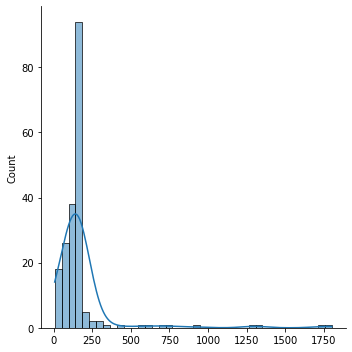

les meilleurs parametres du model: {'dummyregressor__strategy': 'mean'},
 meilleur score: -0.013476614338964455


In [ ]:
params={'dummyregressor__strategy':['mean', 'median', ]}
pre=preprocessor
model0=regression_model(pre=pre, model=DummyRegressor(), params=params)
print(f"les meilleurs parametres du model: {model0.best_params_},\n meilleur score: {model0.best_score_}")

In [ ]:
df.dtypes

BuildingType               object
PrimaryPropertyType        object
Address                    object
ZipCode                   float64
Neighborhood               object
Latitude                  float64
Longitude                 float64
YearBuilt                 float64
NumberofFloors            float64
PropertyGFATotal          float64
LargestPropertyUseType     object
ENERGYSTARScore           float64
SourceEUI(kBtu/sf)        float64
SiteEnergyUse(kBtu)       float64
SteamUse(kBtu)            float64
Electricity(kBtu)         float64
NaturalGas(kBtu)          float64
ComplianceStatus          float64
TotalGHGEmissions         float64
dtype: object

In [ ]:
#for i in quan:
  #df[i]=df[i].apply(lambda x: np.isfinite(x))

In [ ]:
df

,BuildingType,PrimaryPropertyType,Address,ZipCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions
0,NonResidential,Hotel,405 Olive way,11.493753,DOWNTOWN,3.863085,0.0,4.488636,2.484907,11.390012,Hotel,4.094345,5.206750,7226362.50,-5.809143,-6.907755,-6.907755,0.693147,249.98
1,NonResidential,Hotel,724 Pine street,11.493753,DOWNTOWN,3.863106,0.0,2.995732,2.397895,11.547964,Hotel,4.110874,5.171052,8387933.00,0.000000,-6.907755,-5.809143,0.693147,295.86
2,NonResidential,Hotel,1900 5th Avenue,11.493753,DOWNTOWN,3.863127,0.0,3.850148,3.713572,13.770628,Hotel,3.761200,5.488524,72587024.00,-3.324236,-4.828314,-6.907755,0.693147,2089.28
3,NonResidential,Hotel,620 STEWART ST,11.493753,DOWNTOWN,3.863127,0.0,4.499810,2.302585,11.023861,Hotel,4.025352,5.376204,6794584.00,-5.521461,0.000000,-6.907755,0.693147,286.43
4,NonResidential,Hotel,401 LENORA ST,11.493957,DOWNTOWN,3.863127,0.0,3.583519,2.890372,12.075850,Hotel,4.317488,5.353752,14172606.00,0.000000,-6.907755,-5.298317,0.693147,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,Nonresidential COS,Large Office,400 FAIRVIEW AVE N,11.493834,LAKE UNION,3.863316,0.0,0.693147,2.564949,13.193189,Office,4.584967,4.597138,13239050.00,0.000000,-6.214608,-6.214608,0.693147,245.16
974,NonResidential,Hotel,3926 Aurora Ave N,11.493773,LAKE UNION,3.863988,0.0,0.693147,1.386294,11.750548,Hotel,4.276666,5.132853,6042399.50,0.000000,-6.907755,-6.907755,0.693147,131.02
975,NonResidential,Warehouse,6518 Ellis,11.493824,GREATER DUWAMISH,3.861656,0.0,4.110874,0.000000,10.860632,Non-Refrigerated Warehouse,3.610918,4.625953,3605855.50,0.000000,0.000000,-6.214608,0.693147,157.70
976,NonResidential,Small- and Mid-Sized Office,7277 Perimeter Rd.,11.493824,GREATER DUWAMISH,3.861403,0.0,4.465908,0.693147,10.126231,Office,2.197225,5.905362,4420650.50,0.000000,0.000000,-6.907755,0.693147,134.80


In [ ]:
df.describe()

,ZipCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions
count,978.000000,978.000000,978.0,978.000000,978.000000,978.000000,978.000000,978.000000,9.780000e+02,978.000000,978.000000,978.000000,978.000000,978.000000
mean,11.493912,3.863180,0.0,3.708743,1.106676,11.156180,3.910883,4.838483,8.514099e+06,-0.388801,-2.485188,-2.244773,0.693147,179.638865
std,0.000187,0.000982,0.0,0.839066,0.938432,0.992278,0.930999,0.798267,2.193710e+07,1.442816,3.158439,3.075290,0.000000,686.832009
min,11.492927,3.860940,0.0,0.000000,0.000000,9.698920,0.000000,0.693147,7.971180e+04,-6.907755,-6.907755,-6.907755,0.693147,-0.800000
25%,11.493783,3.862670,0.0,3.332205,0.000000,10.360176,3.784190,4.395991,1.267853e+06,0.000000,-6.214608,-6.214608,0.693147,20.207500
50%,11.493834,3.863106,0.0,3.881511,1.098612,10.895395,4.248495,4.924351,2.829813e+06,0.000000,0.000000,0.000000,0.693147,49.735000
75%,11.493967,3.863862,0.0,4.369448,1.609438,11.756303,4.477337,5.292928,7.725746e+06,0.000000,0.000000,0.000000,0.693147,142.280000
max,11.494751,3.865644,0.0,4.753590,4.595120,14.484478,4.605170,7.870930,2.930908e+08,0.000000,0.000000,0.000000,0.693147,12307.160000


## Modeles linéaires

1. Model Ridge

RMSE: 228.5118219057615, 
 MAE: 168.4514165454802
Moyenne des erreur:  198.48161922562088
Score: 0.3589829334195743



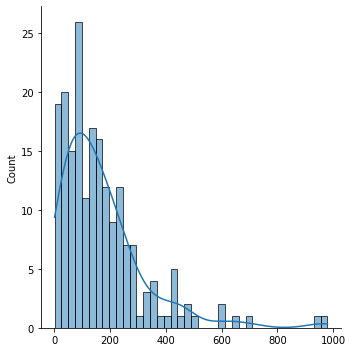

les meilleurs parametres du model: {'ridge__alpha': 21.209508879201927},
 meilleur score: 0.4140542177119516


In [ ]:
params={'ridge__alpha': np.logspace(-5, 5, 50)}
pre=preprocessor
model1=regression_model(pre, model=Ridge(alpha=0.8), params=params)
print(f"les meilleurs parametres du model: {model1.best_params_},\n meilleur score: {model1.best_score_}")

2.Model Lasso

RMSE: 206.46356605996885, 
 MAE: 133.4291708783235
Moyenne des erreur:  169.9463684691462
Score: 0.4767140249351097



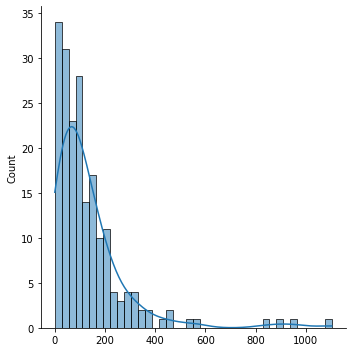

les meilleurs parametres du model: {'lasso__alpha': 27.1858824273294}
, meilleur score: 0.368340698570189


In [ ]:
n_alphas = 100
alpha = np.logspace(-2, 8, n_alphas)
params={'lasso__alpha': alpha}
pre=preprocessor
model2=regression_model(pre,model=Lasso(), params=params)
#model2.best_params_, model2.best_score_
print(f"les meilleurs parametres du model: {model2.best_params_}\n, meilleur score: {model2.best_score_}")

3. Model ElasticNet

In [ ]:
model_=make_pipeline( OneHotEncoder(handle_unknown='ignore'), Lasso())
model_

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('lasso', Lasso())])

RMSE: 232.60908158704265, 
 MAE: 168.32828644747607
Moyenne des erreur:  200.46868401725936
Score: 0.33578974016372964



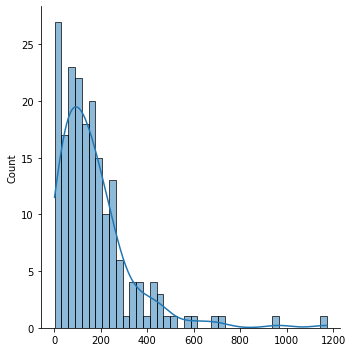


 les meilleurs parametres du model: {'elasticnet__alpha': 0.021544346900318846, 'elasticnet__l1_ratio': 0.0},
 meilleur score: 0.4133913603562491


In [ ]:
params={'elasticnet__alpha':np.logspace(-5, 5, 10), 
'elasticnet__l1_ratio':np.linspace(0,1, 8)
        }
model3=regression_model(pre=preprocessor, model=ElasticNet(), params=params)
print(f"\n les meilleurs parametres du model: {model3.best_params_},\n meilleur score: {model3.best_score_}")

## Les models non linéaires

4. SVR

RMSE: 204.0709656292851, 
 MAE: 80.23662055682266
Moyenne des erreur:  142.15379309305388
Score: 0.026049141751413707



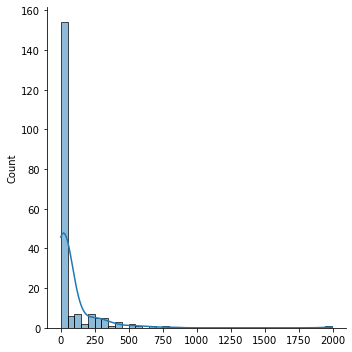

`
 les meilleurs parametres du model: {'svr__C': 1.0, 'svr__gamma': 0.1},
 meilleur score: -0.027777704069181786


In [22]:
params={'svr__C':np.logspace(-2, 0, 6),
        'svr__gamma': np.logspace(-2, 1, 4)}

model4=regression_model(pre=preprocessor, model=SVR(), params=params)
print(f"`\n les meilleurs parametres du model: {model4.best_params_},\n meilleur score: {model4.best_score_}")

5. Ramdom Forest

In [ ]:
model_5=make_pipeline( OneHotEncoder(handle_unknown='ignore'), RandomForestRegressor())
model_5

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

RMSE: 178.61553879932873, 
 MAE: 48.35048239795917
Moyenne des erreur:  113.48301059864394
Score: 0.6083566808232475



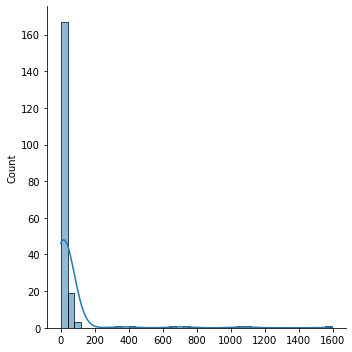

`
 les meilleurs parametres du model: {'randomforestregressor__criterion': 'absolute_error', 'randomforestregressor__max_depth': 30, 'randomforestregressor__n_estimators': 100},
 meilleur score: 0.38149020843983583


In [ ]:
n_estimators = [100,200]
max_depth = [5,15,30,45]
criterion=["squared_error", "absolute_error"] #, "poisson"]
#max_depth = [None]
#min_samples_leaf = [1,3,5,10]
#max_features = ['auto', 'sqrt']
dic={}
dic['randomforestregressor__n_estimators']=n_estimators
dic["randomforestregressor__criterion"]=criterion
#dic['randomforestregressor__min_samples_leaf']=min_samples_leaf
#dic['randomforestregressor__max_features']=max_features
dic['randomforestregressor__max_depth']=max_depth
a=pd.DataFrame(y_train)
X_train['y']=y_train
X_train=X_train[X_train['y']>=0]
y_train=X_train['y']
X_train.drop(columns=['y'], inplace=True)
#params = dict(n_estimators=n_estimators,criterion=criterion, min_samples_leaf=min_samples_leaf , max_features=max_features , max_depth=max_depth)
model5=regression_model(pre=preprocessor, model=RandomForestRegressor(), params=dic)
print(f"`\n les meilleurs parametres du model: {model5.best_params_},\n meilleur score: {model5.best_score_}")

In [ ]:
model5.score(X_test[:75], y_test[:75])

0.8231862201339586

In [ ]:
df.shape

(978, 19)

In [ ]:
y_test.shape

(196,)

Nous allons trouver les meilleurs parametres d'abord apres refaire la prediction

# Explication de l'importance des features

In [ ]:
model5.best_params_

{'randomforestregressor__criterion': 'absolute_error',
 'randomforestregressor__max_depth': 30,
 'randomforestregressor__n_estimators': 100}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import shap
'''explainer= shap.TreeExplainer(model5.best_estimator_[-1])
shap_values = explainer.shap_values(preprocessor.fit_transform(X_train))'''
# Fits the explainer
pro=preprocessor.fit(X_train)
model_i=RandomForestRegressor(criterion="squared_error",max_depth= 45, n_estimators=100 )
model_i.fit(X_train[quan], y_train)
explainer = shap.KernelExplainer(model_i.predict, X_test[quan])

#shap_values = explainer(X_test)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


## Importance Globale

  0%|          | 0/196 [00:00<?, ?it/s]

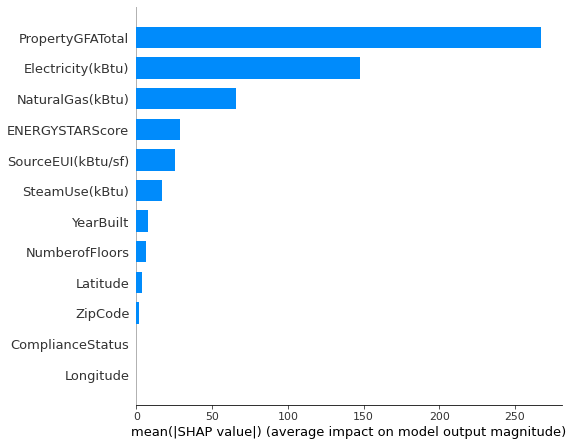

In [ ]:
shap_values = explainer.shap_values(X_test[quan])

# visualize the model's dependence on the first feature
shap.summary_plot(
    shap_values, X_test[quan], 
    feature_names=quan, plot_type="bar"
)

## Importance Locale

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test[quan].iloc[0])
#print(len(shap_values), df0.iloc[0,:].shape)
shap.force_plot(explainer.expected_value, shap_values,X_test[quan].iloc[0])

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# Conclusion


Nous allons garder le RandomForesRegressor comme model choisi car on obtient de bon resultat avec, dans le cas de l'erreur et de precision